In [5]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight


In [35]:
# Paths to dataset
BASE_DIR = "hi"  # Update this to the location of your dataset
CLIPS_DIR = os.path.join(BASE_DIR, "clips")  # Path to audio files
VALIDATED_TSV = os.path.join(BASE_DIR, "validated.tsv")  # Path to the validated.tsv file

# Load and preview the validated.tsv file
df = pd.read_csv(VALIDATED_TSV, sep="\t")
#print(df.head())  # Display the first few rows

# Extract file paths and labels
file_paths = df["path"].values  # Get file names from the 'path' column
labels = df["sentence"].values  # Get labels (spoken words) from the 'sentence' column

# Combine file paths with the audio directory
file_paths = [os.path.join(CLIPS_DIR, file) for file in file_paths]

# Check if the first audio file exists
if not os.path.exists(file_paths[0]):
    raise FileNotFoundError(f"Audio file not found: {file_paths[0]}")

print(f"First audio file: {file_paths[0]}")
print(f"First label: {labels[0]}")

# Function to preprocess audio
def preprocess_audio(file_path, target_shape=(64, 64)):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=16000)

        # Pad or trim the audio to 1 second (16000 samples)
        if len(audio) < 16000:
            audio = np.pad(audio, (0, 16000 - len(audio)), mode="constant")
        else:
            audio = audio[:16000]
        audio = librosa.util.normalize(audio)

        # Generate Mel spectrogram
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, fmax=16000)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # Resize spectrogram to target shape
        resized_spectrogram = tf.image.resize(log_spectrogram[..., np.newaxis], target_shape)  # Add channel dim
        return resized_spectrogram.numpy()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load dataset from validated.tsv
def load_dataset(clips_dir, validated_tsv, target_shape=(64, 64)):
    data = []
    labels = []

    # Read the metadata
    metadata = pd.read_csv(validated_tsv, sep="\t")

    # Iterate over rows and process files
    for _, row in metadata.iterrows():
        file_path = os.path.join(clips_dir, row["path"])
        if os.path.exists(file_path):
            spectrogram = preprocess_audio(file_path, target_shape=target_shape)
            if spectrogram is not None:
                data.append(spectrogram)
                labels.append(row["sentence"])  # Use sentence as the label (or adapt as needed)

    return np.array(data), labels
# Function to create the embedding model
def create_embedding_model(input_shape=(64, 64, 1), num_classes=10):
    # Load the MobileNetV2 base model
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
    
    # Global average pooling layer
    x = layers.GlobalAveragePooling2D()(base_model.output)
    # Reshape output for LSTM input
    x = layers.Reshape((1, -1))(x)
    # LSTM layer with increased units
    x = layers.LSTM(256, return_sequences=False)(x)
    # Fully connected layer with BatchNormalization and Dropout
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Dropout to prevent overfitting
    # Output layer adjusted for number of classes
    output = layers.Dense(num_classes, activation="softmax")(x)
    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)
    
    return model

import matplotlib.pyplot as plt

def display_waveform(file_path, sample_rate=16000):
    """
    Load audio and display its waveform.
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr, alpha=0.8)
    plt.title("Waveform of the Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


First audio file: hi\clips\common_voice_hi_30196032.mp3
First label: महिलाओं को दरगाह में घुसने से नहीं रोक सकते ट्रस्टीः महाराष्ट्र सरकार


Loading and preprocessing dataset...


C:\Users\NISHIT\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Data shape after preprocessing: (10279, 64, 64, 1)


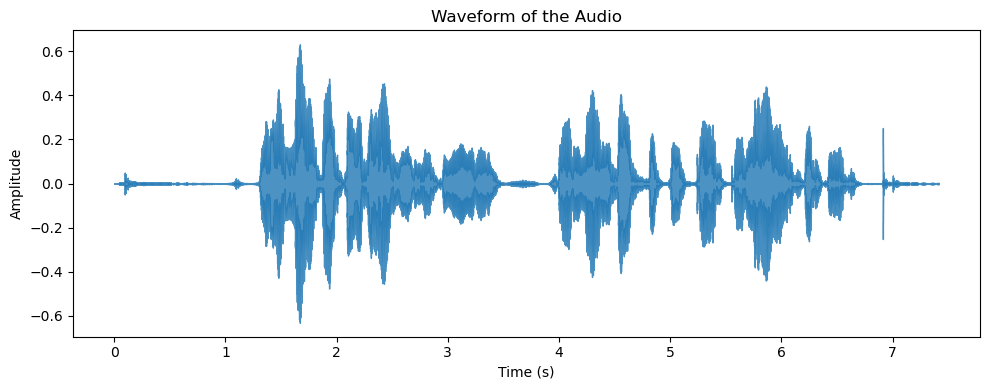

In [37]:

print("Loading and preprocessing dataset...")
data, labels = load_dataset(CLIPS_DIR, VALIDATED_TSV, target_shape=(64, 64))

# Debug: Verify the shape of the data
print(f"Data shape after preprocessing: {data.shape}")  # Should be (num_samples, 64, 64, 1)
#print(f"Labels shape after preprocessing: {labels.shape}")  # Should be (num_samples, num_classes)

# Convert text labels to numeric (optional, if needed for classification)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
numeric_labels = encoder.fit_transform(labels)
categorical_labels = to_categorical(numeric_labels)

# Display the waveform for the first audio file
# Combine file paths with the audio directory
display_waveform(file_paths[0])

In [39]:

#Split dataset
x_train, x_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
#x_train = x_train / 255.0
#x_test = x_test / 255.0

# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)
# Create model
print("Creating the embedding model...")
num_classes = len(encoder.classes_)  # Get the number of unique classes

embedding_model = create_embedding_model(input_shape=(64, 64, 1), num_classes=num_classes)
embedding_model.compile(optimizer=Adam(learning_rate=0.0001) , loss="categorical_crossentropy", metrics=["accuracy"])
#embedding_model.summary()

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

class_weights = compute_class_weight(
    "balanced", classes=np.unique(numeric_labels), y=numeric_labels
)
class_weights_dict = dict(enumerate(class_weights))

history = embedding_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)
from sklearn.metrics import classification_report

y_pred = embedding_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

# Train model
#print("Training model...")

#model = create_improved_model(input_shape=(64, 64, 1), num_classes=len(encoder.classes_))
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# Compile the model with a smaller learning rate
#optimizer = Adam(learning_rate=1e-5)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping and learning rate scheduler
# Train the model
#history = model.fit(
 #   datagen.flow(x_train, y_train, batch_size=64),  # Use augmented data
  #  epochs=50,
   # validation_data=(x_test, y_test),
    #callbacks=[early_stopping, lr_scheduler]
#)

Creating the embedding model...
Epoch 1/10


C:\Users\NISHIT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 108s 613ms/step - accuracy: 0.0000e+00 - loss: 10.2760 - val_accuracy: 0.0000e+00 - val_loss: 9.3983 - learning_rate: 0.0010
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 77s 595ms/step - accuracy: 5.7825e-04 - loss: 9.2799 - val_accuracy: 0.0000e+00 - val_loss: 9.6658 - learning_rate: 0.0010
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 82s 635ms/step - accuracy: 0.0000e+00 - loss: 9.1674 - val_accuracy: 0.0000e+00 - val_loss: 10.7589 - learning_rate: 0.0010
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 77s 597ms/step - accuracy: 0.0000e+00 - loss: 9.0916 - val_accuracy: 0.0000e+00 - val_loss: 11.3098 - learning_rate: 0.0010
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 75s 585ms/step - accuracy: 1.4787e-04 - loss: 8.9968 - val_accuracy: 0.0000e+00 - val_loss: 11.8243 - learning_rate: 5.0000e-04
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 72s 560ms/step - accuracy: 3.3469e-04 - loss: 8.9332 - val_accuracy: 0.0000e+00 - val_loss: 11.9915 - learning_rate: 5.0000e-04
65/65 ━━━━━━━━━━━━━

C:\Users\NISHIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NISHIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NISHIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NISHIT\anaconda3\Lib\site-packages\s